# Housing data analysis 

## Objectives

## Data download and structure

In [25]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# downloading data
import os
import tarfile
import urllib

# set up paths
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
import pandas as pd

# set up download data function
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path,  exist_ok = True)
    tgz_path = os.path.join(housing_path,  "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

# loading data function
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
# try to load data, if data was not downloaded, go to exception
try:
    # load data
    housing = load_housing_data()
except:
    # download data
    fetch_housing_data()
    # load data
    housing = load_housing_data()    

In [5]:
# data structure
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Some insights we already can get from the structure:
1. There are 20,640 instances.
2. 207 regions lack `total_bedrooms` data.
3. `ocean_proximity` probably is categoric.

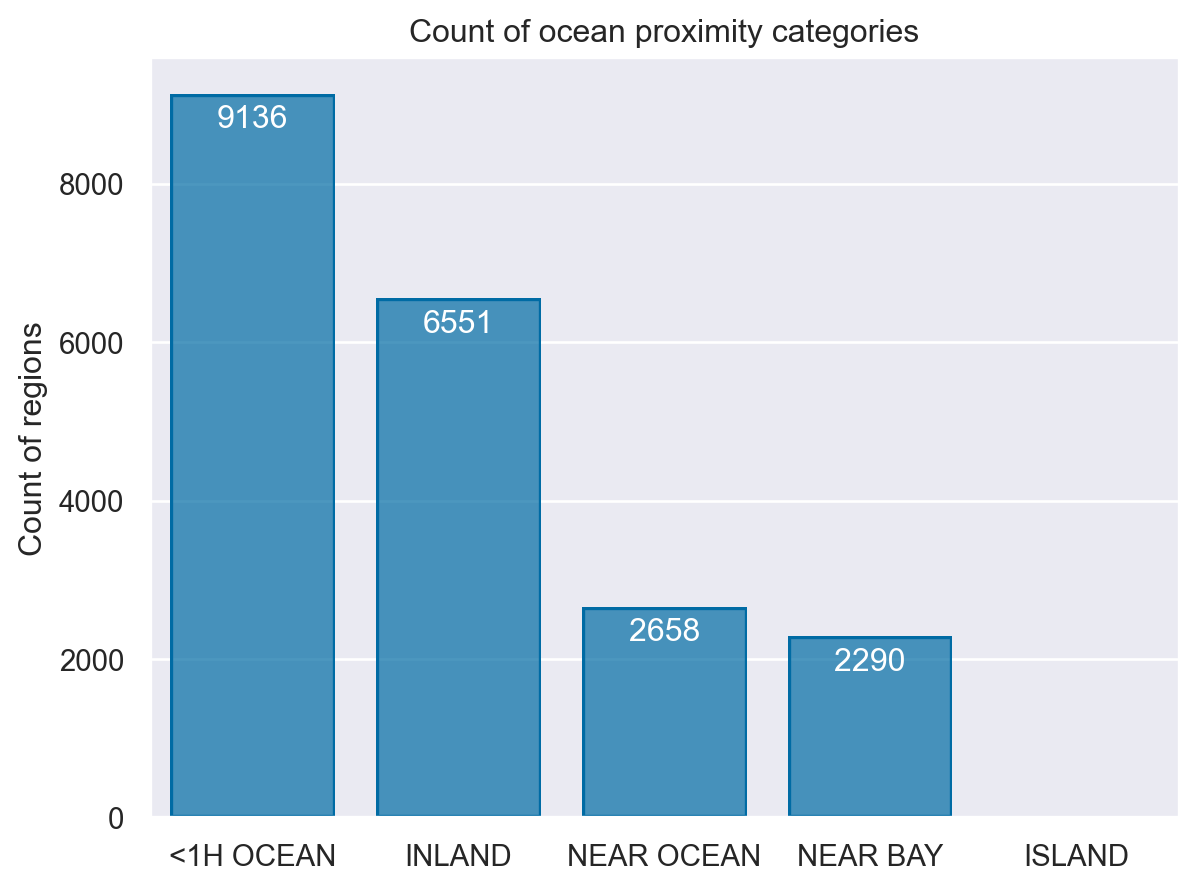

In [7]:
# identify categories and count in ocean_proximity
import seaborn.objects as so
from matplotlib import style
import warnings

# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

vc = housing["ocean_proximity"].value_counts()
(
    so.Plot(x = vc.index, y = vc, text = vc)
    .add(so.Bar())
    .add(so.Text(color = "w", valign = "top"))
).\
    label(title = "Count of ocean proximity categories"
          , x = "" 
          , y = "Count of regions").\
          theme({**style.library["tableau-colorblind10"]})

There are more regions `< 1H OCEAN` than `INLAND`. This can be included for later analysis.

In [9]:
# summary of numeric data
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


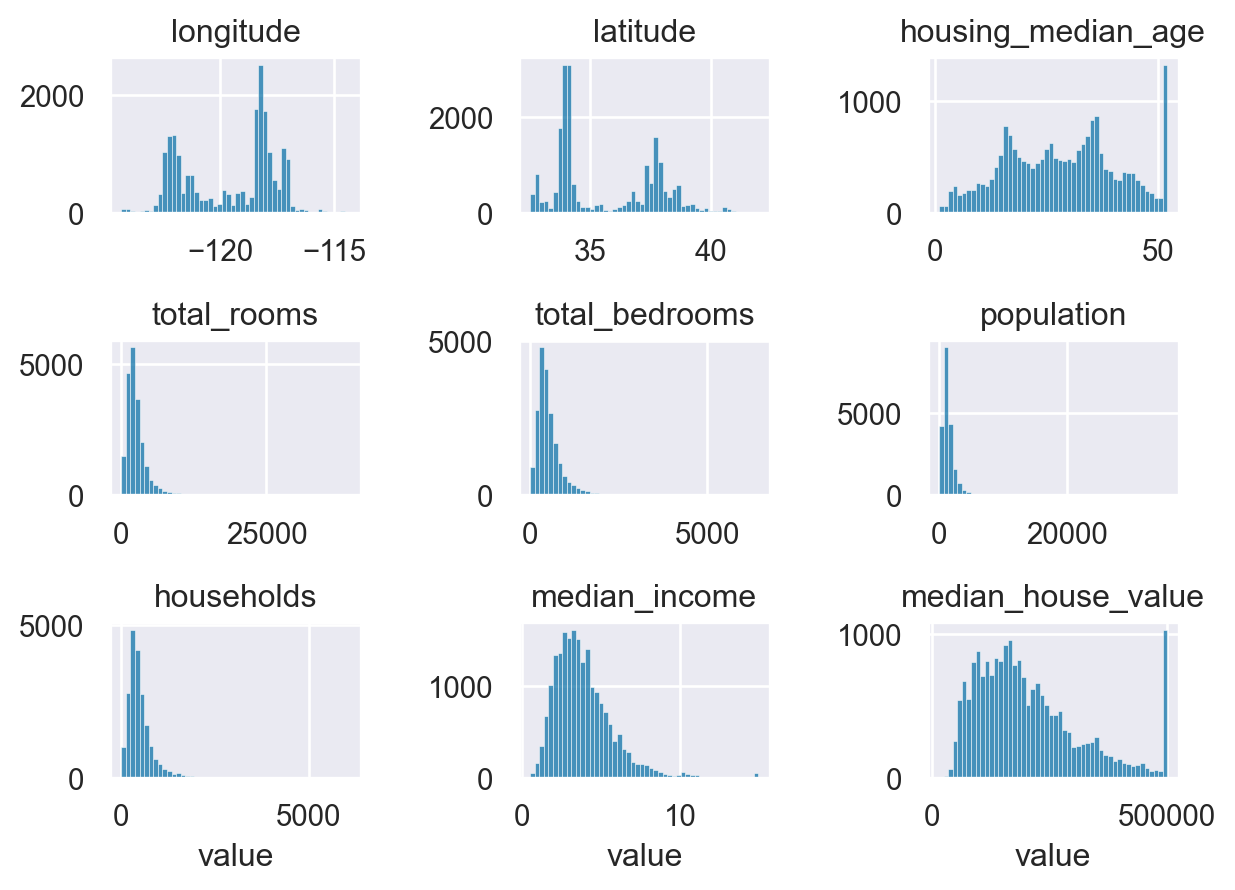

In [31]:
lg = housing.select_dtypes(include="float64").melt()
(
    so.Plot(lg, x = "value")
    .add(so.Bars(), so.Hist(bins = 50, common_bins = False))
    .facet(col = "variable", wrap = 3)
    .share(x = False, y = False)
    .theme({**style.library["tableau-colorblind10"]})
)

The main takeouts of the charts:

1. the `median_income` is not in USD (min: 0.49; max: 15)
2. the high counts for the last values of `housing_median_age` and `median_house_value` indicates that it was proposed a threshold for both features.
3. the features have different scales and they do not seem to have a Gauss distribution.

## Test set

To avoid confusion (the *data snooping bias*), we're going to split the data into the `train_set` and `test_set` before the complete EDA.

In [32]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = .2, random_state = 42)

However, the model would benefit from stratification of the `train_set` by  the `median_income`. Therefore, we will create a new feature with income categories.

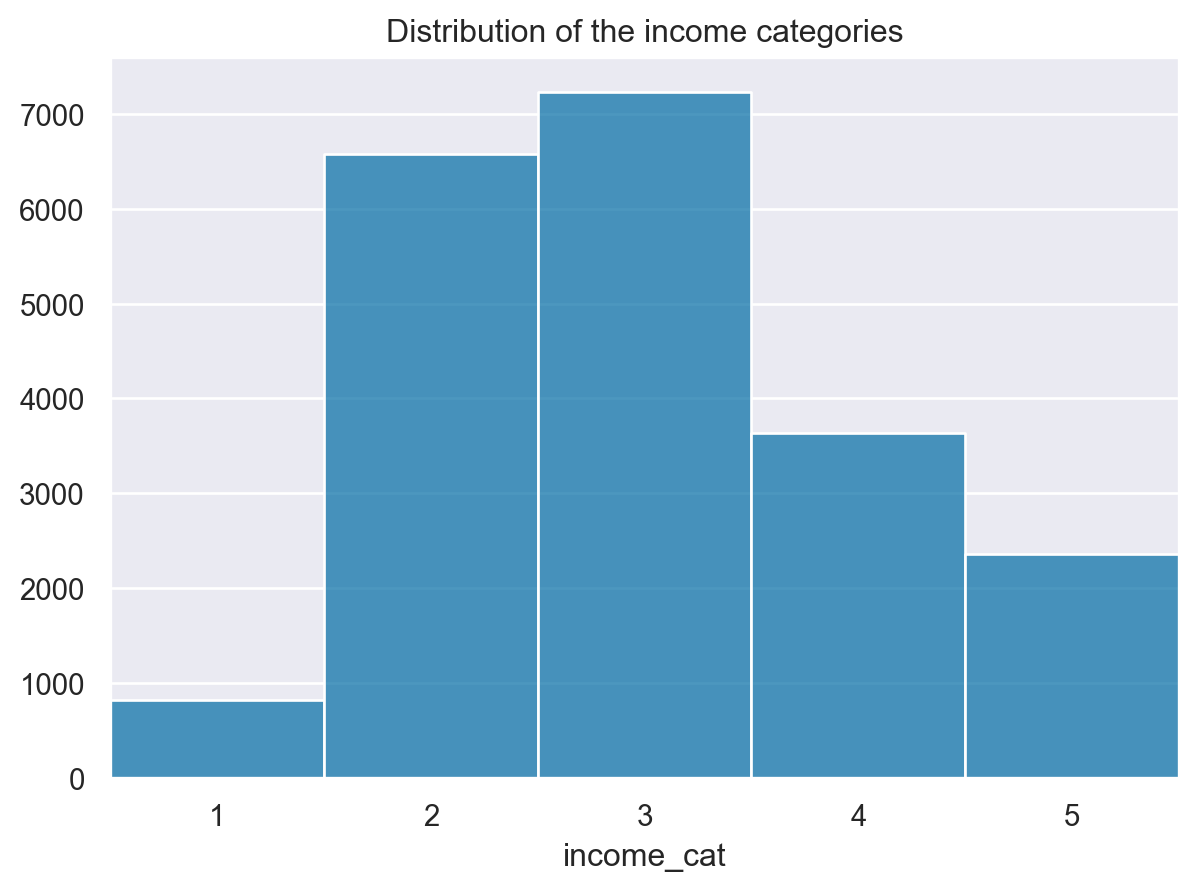

In [38]:
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins = [0., 1.5, 3., 4.5, 6., np.inf],
                               labels = [1, 2, 3, 4, 5])

(
    so.Plot(x = housing["income_cat"])
    .add(so.Bars(), so.Hist())
    .label(title = "Distribution of the income categories")
    .theme({**style.library["tableau-colorblind10"]})
)

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

# set up the function
split = StratifiedShuffleSplit(n_splits = 1, test_size = .2, random_state = 42)
# apply the split
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [47]:
# checking if the stratification is the same of the original proportions
strat_train_set["income_cat"].value_counts(normalize = True).round(2) == housing["income_cat"].value_counts(normalize = True).round(2)

income_cat
3    True
2    True
4    True
5    True
1    True
Name: proportion, dtype: bool

In [48]:
# removing income_cat
for set_ in (strat_test_set, strat_train_set):
    set_.drop("income_cat", axis = 1, inplace = True)